# Imports

In [1]:
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50

import numpy as np
# import tensorflow_hub as hub
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import time
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import class_weight
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
import glob

print(tf.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")




2.18.0
Using device: cuda


**FUNCTIONS**

In [30]:
import torch.nn.functional as F

def train_and_validate(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=5):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        # lr = optimizer.param_groups[0]['lr']

        print(f"=====================================Epoch: {epoch + 1} / {num_epochs}=====================================")
        train_progress = tqdm(train_loader, total=len(train_loader), leave=True)

        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            train_progress.set_description(f'[TRAIN] ')
            
        train_loss /= len(train_loader.dataset)
        train_acc = correct / total

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        val_progress = tqdm(val_loader, total=len(val_loader), leave=True)
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0) # 1

                probs = F.softmax(outputs, dim=1) # 3
                _, predicted = torch.max(probs, 1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

                val_progress.set_description(f'[VALID] ')

        val_loss /= len(val_loader.dataset) # 2
        val_acc = correct / total

        print(f'=> Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f} |  Train Acc={train_acc:.4f},  Val Acc={val_acc:.4f}')

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # scheduler.step()

    
    return history

def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)


def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

def preprocess_image2(image):
    """ 
    Preprocesses an image tensor to make it model ready.
    Args:
        image: Tensor representing the image.
    """
    # If PNG and has 4 channels, remove the alpha channel.
    if image.shape[-1] == 4:
        image = image[..., :-1]
    
    # Ensure the height and width are divisible by 4
    hr_size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
    image = tf.image.crop_to_bounding_box(image, 0, 0, hr_size[0], hr_size[1])
    
    # Cast image to float32
    image = tf.cast(image, tf.float32)
    
    # Add batch dimension
    return tf.expand_dims(image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

  

def pad_to_square(image):
    # Get original dimensions
    old_h, old_w = image.shape[:2]
    
    # Find the larger dimension to make the image square
    max_dim = max(old_h, old_w)
    
    # Calculate padding
    pad_h = (max_dim - old_h) // 2
    pad_w = (max_dim - old_w) // 2
    
    # Ensure padding is non-negative and compatible
    padded_image = tf.image.pad_to_bounding_box(image, pad_h, pad_w, max_dim, max_dim)
    
    # Handle any excess due to rounding differences
    padded_image = tf.image.resize_with_crop_or_pad(padded_image, max_dim, max_dim)
    
    return padded_image

def get_image_index(file_name, image_dir="./data/DATASET/TRAIN_UNET/enhanced_images/*.jpg"):
    """
    Retrieves the index of an image file name in the list of loaded images.
    
    Args:
        file_name (str): The file name of the image (e.g., 'image1.jpg').
        image_dir (str): The directory path of the images.

    Returns:
        int: The index of the image in the list of images, or -1 if not found.
    """
    for idx, img_path in enumerate(glob.glob(image_dir)):
        if file_name in img_path:
            return idx
    return -1

%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

from tqdm import tqdm

# Training and evaluation loop
def train_model(model, dataloader, val_dataloader, optimizer, criterion, epochs, device):
    # Initialize lists to store metrics for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Create a tqdm progress bar for the dataloader
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", ncols=100, unit="batch")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=running_loss/total, accuracy=correct/total)

        # Calculate training accuracy
        train_loss = running_loss / len(dataloader)
        train_acc = correct / total

        # Evaluate on the validation set
        val_acc, val_loss = evaluate_model(model, val_dataloader, criterion)

        # Save metrics for this epoch
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Return the history for further processing (such as saving or plotting)
    history = {
        'epoch': range(1, epochs + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    return history  # Return the history dictionary


# Evaluation loop
def evaluate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    return val_acc, val_loss / len(dataloader)

def test_model(model, test_dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# Define the function for predicting and measuring speed
def predict_image(model, image_path, device, class_labels):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ResNet's requirements
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model
    image = image.to(device)

    # Start time for inference
    start_time = time.time()

    # Perform inference
    model.eval()
    with torch.no_grad():
        outputs = model(image)

    # Calculate prediction probabilities using softmax
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Get the predicted class and its probability
    predicted_class_index = probabilities.argmax().item()
    predicted_class = class_labels[predicted_class_index]
    prediction_time = time.time() - start_time

    return predicted_class, prediction_time, probabilities[0]  # Return class, time, and probabilities

def predict_image_with_debug(model, image_path, device, class_labels):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    # Start time for inference
    start_time = time.time()

    # Perform inference
    model.eval()
    with torch.no_grad():
        logits = model(image)  # Raw logits from the model

    # Print raw logits before softmax
    print("Logits:", logits)

    # Calculate probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Plot class probabilities
    plt.bar(range(len(class_labels)), probabilities[0].cpu().numpy())
    plt.xticks(range(len(class_labels)), class_labels, rotation=90)
    plt.show()

    # Get predicted class and its probability
    predicted_class_index = probabilities.argmax().item()
    predicted_class = class_labels[predicted_class_index]
    confidence = probabilities.max().item()
    prediction_time = time.time() - start_time

    return predicted_class, confidence, prediction_time

def plot_from_history(history):
    # Extract data from the history dictionary
    epochs = len(history['epoch'])
    train_losses = history['train_loss']
    val_losses = history['val_loss']
    train_accuracies = history['train_accuracy']
    val_accuracies = history['val_accuracy']

    # Plot the metrics
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Save the plot
    plt.tight_layout()
    plt.savefig('training_history.png')  # Save the plot as a PNG image
    plt.show()
    
def get_class_labels(dataset_dir):
    # Get all folder names in the directory, which are your class labels
    class_labels = sorted(os.listdir(dataset_dir))  # Assuming each subfolder is a class
    return class_labels

# Dataset Preparation

In [31]:
train_dir = './DATASET/TRAIN'
enhancedtrain_dir = './DATASET/TRAIN_ESRGAN - ESRGAN'
test_dir = './DATASET/TEST - mergedval'
enhancedtest_dir = './DATASET/TEST_ESRGAN - ESRGAN-mergedval'
validation_dir = './DATASET/VALIDATION'
enhancedval_dir = './DATASET/VALIDATION_ESRGAN - ESRGAN'

seed = 42
np.random.seed(seed)
random.seed(seed)


**AUGMENTED**

In [4]:


img_height, img_width = 224, 224
batch_size = 32


tf.random.set_seed(seed)



# Option 1
# train_datagen = ImageDataGenerator(
#    rescale=1./255,
#    rotation_range=90,
#    shear_range=0.2,       # Random shear
#    zoom_range=0.2,        # Random zoom
#    brightness_range=[0.8, 1.2],  
#    fill_mode='nearest'
# )


# Option 2
# train_datagen = ImageDataGenerator(
#    rescale=1./255,
#    rotation_range=90,  # rotation up to 90 degrees, ensures range includes 30, 60, and 90 degrees
#    brightness_range=[0.8, 1.2],  # light intensity adjustment
#    horizontal_flip=True,
#    vertical_flip=True,
#    fill_mode='nearest'
# )

# Option 3
# train_datagen = ImageDataGenerator(
#     rescale=1./255,         # Scale pixel values to [0, 1]
#     rotation_range=30,      # Random rotation
#     width_shift_range=0.2,  # Random width shift
#     height_shift_range=0.2, # Random height shift
#     shear_range=0.2,       # Random shear
#     zoom_range=0.2,        # Random zoom
#     horizontal_flip=True,   # Random horizontal flip
#     fill_mode='nearest'     # Fill mode for new pixels
# )

# Option 4
train_datagen = ImageDataGenerator(
#                                   rescale=1./255,
#                                   zoom_range=0.2,
#                                   rotation_range=30,
                                   brightness_range=[0.8, 1.2],
                                   preprocessing_function=preprocess_input,
#                                   fill_mode='nearest',
                                   )

enhancedtrain_datagen = ImageDataGenerator(
#                                   rescale=1./255,
#                                   zoom_range=0.2,
#                                   rotation_range=30,
                                   preprocessing_function=preprocess_input,
                                   brightness_range=[0.8, 1.2],
#                                   fill_mode='nearest',
                                   )



test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


enhancedval_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
enhancedtest_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)


validation_generator = validation_datagen.flow_from_directory(
    test_dir,  
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

enhancedtrain_generator = enhancedtrain_datagen.flow_from_directory(
    enhancedtrain_dir,
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

enhancedvalidation_generator = enhancedval_datagen.flow_from_directory(
    enhancedtest_dir,  
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

enhancedtest_generator = enhancedtest_datagen.flow_from_directory(
    enhancedtest_dir,  
    target_size=(img_height, img_width),  
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

Found 1679 images belonging to 18 classes.
Found 720 images belonging to 18 classes.
Found 720 images belonging to 18 classes.
Found 1679 images belonging to 18 classes.
Found 720 images belonging to 18 classes.
Found 720 images belonging to 18 classes.


**PYTORCH**

In [ ]:

import random

from sklearn.utils import compute_class_weight

# Hyperparameters
img_height, img_width = 224, 224
batch_size = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False  # Ensures deterministic behavior


# Data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    #transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.8,1.2), shear=5),
#    transforms.ColorJitter(brightness=(0.8, 1.2)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomResizedCrop((img_height, img_width), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=val_test_transform) # train transform for augmented
val_dataset = datasets.ImageFolder(validation_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Enhanced datasets
enhanced_train_dataset = datasets.ImageFolder(enhancedtrain_dir, transform=val_test_transform) # train transform for augmented
enhanced_val_dataset = datasets.ImageFolder(enhancedval_dir, transform=val_test_transform)
enhanced_test_dataset = datasets.ImageFolder(enhancedtest_dir, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

enhanced_train_loader = DataLoader(enhanced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
enhanced_val_loader = DataLoader(enhanced_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
enhanced_test_loader = DataLoader(enhanced_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

y_true = [sample[1] for sample in train_dataset.samples]  # Extract the labels (index 1 in each tuple)

# Compute class weights based on the class distribution in y_true
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_true), y=y_true)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Number of images in training set: {len(train_dataset)}")
print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")

print(f"Number of images in enhanced training set: {len(enhanced_train_dataset)}")
print(f"Number of images in enhanced validation set: {len(enhanced_val_dataset)}")
print(f"Number of images in enhanced test set: {len(enhanced_test_dataset)}")


Number of images in training set: 1679
Number of images in validation set: 474
Number of images in test set: 720
Number of images in enhanced training set: 1679
Number of images in enhanced validation set: 474
Number of images in enhanced test set: 720


# Baseline

In [ ]:
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)
print("Running on GPU" if tf.config.list_physical_devices('GPU') else "Running on CPU")
# Check if CUDA and cuDNN are available
print("Is built with GPU support:", tf.config.list_physical_devices('GPU'))
print("Is cuDNN available:", tf.test.is_gpu_available())


In [66]:
baseline_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#143 LAYERS ORIGINAL
for layer in baseline_model.layers[:]:  
    layer.trainable = False


for i, layer in enumerate(baseline_model.layers):
   print(i, layer.name, layer.trainable)

0 input_layer_7 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv

In [67]:
x = baseline_model.output

x = GlobalAveragePooling2D()(x)


output_layer = Dense(18, activation="softmax", name='classification_output')(x)

# Final model
basemodel = Model(inputs=baseline_model.input, outputs=output_layer, name="baseline_ResNet-50")




In [ ]:

initial_lr = 0.001

optimizer = Adamax(learning_rate=initial_lr)

basemodel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

basemodel.summary()

In [32]:
y_true = test_generator.classes

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_true),  
    y=y_true  
)

class_weight_dict = dict(enumerate(class_weights))

print(y_true)
print(class_weight_dict)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7]
{0: 1.130952380952381, 1: 1.6964285714285714, 2: 1.25, 3: 0.9895833333333334, 4: 1.1875, 5: 0.5277777777777778, 6: 0.8189655172413793, 7: 1.3194444444444444}


**TRAIN**

In [ ]:
#checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00001)

baseline_history = basemodel.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=5,
    #class_weight = class_weight_dict,
    validation_freq=1,
    verbose=1,
)


In [42]:
# Evaluate the model on the test set
test_loss, test_acc = basemodel.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9937 - loss: 0.0473
Test Accuracy: 98.37%


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = basemodel.evaluate(enhancedtest_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

**END======================================Save Model======================================END**

In [11]:
basemodel.save('./saved_models/resnetb8augepoch5layer81acc93finalenhanced94+noOverfitBEST.h5')

with open('./saved_models/resnetb8augepoch5layer81acc93finalenhanced94+noOverfitBEST_history.pkl', 'wb') as file:
    pickle.dump(baseline_history.history, file)

**LOAD MODEL**

In [37]:
baseline_saved = tf.keras.models.load_model('./saved_models/resnetb16augepoch5layer81acc93enhanced92.h5')


# with open('./saved_models/resnetb16augepoch5layer81acc90enhanced90+53_history.pkl', 'rb') as file:
#     loaded_history = pickle.load(file)

In [ ]:
test_loss, test_acc = baseline_saved.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

In [ ]:
test_loss, test_acc = baseline_saved.evaluate(enhancedtest_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

**TEST THE MODEL**

In [ ]:
y_pred = basemodel.predict(enhancedtest_generator)
y_pred_classes = y_pred.argmax(axis=1)  

y_true = enhancedtest_generator.classes


for i in range(10):  # Checking the first 10 predictions
    print(f"True Label: {y_true[i]}, Predicted Label: {y_pred_classes[i]}")

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=enhancedtest_generator.class_indices.keys()))

f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

In [43]:
y_pred = basemodel.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)

y_true = test_generator.classes


for i in range(10):  # Checking the first 10 predictions
    print(f"True Label: {y_true[i]}, Predicted Label: {y_pred_classes[i]}")

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       1.00      1.00      1.00        11
 Acanthurus Nigrofuscus       0.91      1.00      0.95        21
   Balistapus Undulatus       1.00      1.00      1.00         5
 Canthigaster Valentini       1.00      1.00      1.00        14
 Chaetodon Trifascialis       0.90      1.00      0.95        19
   Hemigymnus Fasciatus       1.00      1.00      1.00        24
  Hemigymnus Melapterus       1.00      1.00      1.00         5
        Lutjanus fulvus       1.00      1.00      1.00        20
     Myriprist

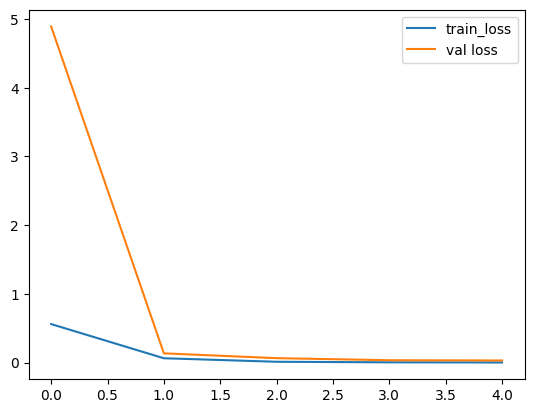

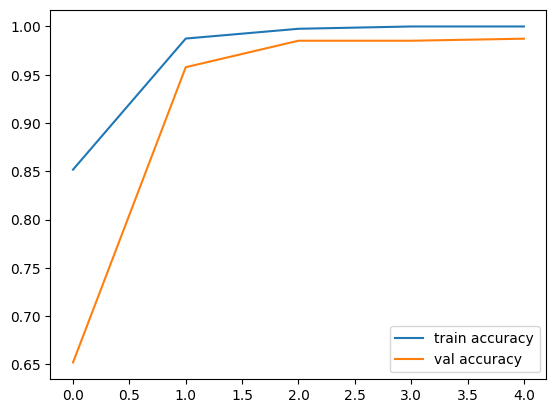

In [44]:
# Plot the Loss

plt.plot(baseline_history.history['loss'], label = 'train_loss')
plt.plot(baseline_history.history['val_loss'], label ='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# Plot the Accuracy
plt.plot(baseline_history.history['accuracy'], label = 'train accuracy')
plt.plot(baseline_history.history['val_accuracy'], label ='val accuracy')
plt.legend()
plt.show()
# plt.savefig('valAccuracy')


**WITH LOADED**

In [ ]:
# Plot the Loss
plt.plot(loaded_history['loss'], label='train_loss')
plt.plot(loaded_history['val_loss'], label='val_loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss.png')

# Plot the Accuracy
plt.plot(loaded_history['accuracy'], label='train_accuracy')
plt.plot(loaded_history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
# plt.savefig('valAccuracy.png')


# PYTORCH (BASELINE)

In [60]:
learning_rate = 0.001
epochs = 30


torch_baseline = resnet50(weights="IMAGENET1K_V1").to(device)

# Freeze the initial 39 layers
# freeze = True
# for name, layer in torch_baseline.named_modules():
#     # Explicitly freeze all layers up to layer3
#     if 'layer4' in name:
#         freeze = False  # Start unfreezing at layer3
#     if freeze:
#         for param in layer.parameters():
#             param.requires_grad = False
#     else:
#         for param in layer.parameters():
#             param.requires_grad = True

# FREEZE ALL LAYERS
for param in torch_baseline.parameters():
    param.requires_grad = False

class BaselineResNet(nn.Module):
    def __init__(self, base_model, num_classes=18):
        super(BaselineResNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude top layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)  # 2048 (gap) + 2048 (gmp) = 4096

    def forward(self, x):
        x = self.base_model(x)
        gap = self.gap(x).view(x.size(0), -1)
        x = self.fc(gap)
        return x


torch_baseline_model = BaselineResNet(torch_baseline).to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adamax(torch_baseline_model.fc.parameters(), lr=learning_rate)

for name, layer in torch_baseline_model.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')



: True
base_model: False
base_model.0: False
base_model.1: False
base_model.2: False
base_model.3: False
base_model.4: False
base_model.4.0: False
base_model.4.0.conv1: False
base_model.4.0.bn1: False
base_model.4.0.conv2: False
base_model.4.0.bn2: False
base_model.4.0.conv3: False
base_model.4.0.bn3: False
base_model.4.0.relu: False
base_model.4.0.downsample: False
base_model.4.0.downsample.0: False
base_model.4.0.downsample.1: False
base_model.4.1: False
base_model.4.1.conv1: False
base_model.4.1.bn1: False
base_model.4.1.conv2: False
base_model.4.1.bn2: False
base_model.4.1.conv3: False
base_model.4.1.bn3: False
base_model.4.1.relu: False
base_model.4.2: False
base_model.4.2.conv1: False
base_model.4.2.bn1: False
base_model.4.2.conv2: False
base_model.4.2.bn2: False
base_model.4.2.conv3: False
base_model.4.2.bn3: False
base_model.4.2.relu: False
base_model.5: False
base_model.5.0: False
base_model.5.0.conv1: False
base_model.5.0.bn1: False
base_model.5.0.conv2: False
base_model.5.0.

In [56]:
baseline_history = train_and_validate(torch_baseline_model, criterion, optimizer, train_loader, test_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:30<00:00,  1.46it/s]


=> Train Loss=2.4544, Val Loss=1.5498 |  Train Acc=0.4592,  Val Acc=0.7222
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:30<00:00,  1.48it/s]


=> Train Loss=1.6606, Val Loss=1.1435 |  Train Acc=0.7772,  Val Acc=0.8097
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:31<00:00,  1.42it/s]


=> Train Loss=1.2936, Val Loss=0.9673 |  Train Acc=0.8362,  Val Acc=0.8444
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:29<00:00,  1.52it/s]


=> Train Loss=1.0832, Val Loss=0.8244 |  Train Acc=0.8565,  Val Acc=0.8514
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.84it/s]


=> Train Loss=0.9116, Val Loss=0.7070 |  Train Acc=0.8749,  Val Acc=0.8708
=====================================Epoch: 6 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.85it/s]


=> Train Loss=0.7959, Val Loss=0.6211 |  Train Acc=0.8892,  Val Acc=0.8847
=====================================Epoch: 7 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.94it/s]


=> Train Loss=0.7040, Val Loss=0.5931 |  Train Acc=0.9017,  Val Acc=0.8917
=====================================Epoch: 8 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.07it/s]


=> Train Loss=0.6524, Val Loss=0.5278 |  Train Acc=0.9059,  Val Acc=0.8986
=====================================Epoch: 9 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.03it/s]


=> Train Loss=0.5776, Val Loss=0.4924 |  Train Acc=0.9119,  Val Acc=0.9014
=====================================Epoch: 10 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.80it/s]


=> Train Loss=0.5333, Val Loss=0.4622 |  Train Acc=0.9130,  Val Acc=0.9083
=====================================Epoch: 11 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.09it/s]


=> Train Loss=0.4749, Val Loss=0.4345 |  Train Acc=0.9279,  Val Acc=0.9208
=====================================Epoch: 12 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.03it/s]


=> Train Loss=0.4706, Val Loss=0.4456 |  Train Acc=0.9214,  Val Acc=0.9014
=====================================Epoch: 13 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.16it/s]


=> Train Loss=0.4239, Val Loss=0.4090 |  Train Acc=0.9202,  Val Acc=0.9069
=====================================Epoch: 14 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.55it/s]


=> Train Loss=0.3764, Val Loss=0.3701 |  Train Acc=0.9375,  Val Acc=0.9208
=====================================Epoch: 15 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.74it/s]


=> Train Loss=0.3663, Val Loss=0.3676 |  Train Acc=0.9375,  Val Acc=0.9097
=====================================Epoch: 16 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.23it/s]


=> Train Loss=0.3606, Val Loss=0.3716 |  Train Acc=0.9369,  Val Acc=0.9056
=====================================Epoch: 17 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.08it/s]


=> Train Loss=0.3428, Val Loss=0.3457 |  Train Acc=0.9345,  Val Acc=0.9236
=====================================Epoch: 18 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.05it/s]


=> Train Loss=0.3239, Val Loss=0.3203 |  Train Acc=0.9381,  Val Acc=0.9306
=====================================Epoch: 19 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.85it/s]


=> Train Loss=0.3062, Val Loss=0.3116 |  Train Acc=0.9369,  Val Acc=0.9319
=====================================Epoch: 20 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:12<00:00,  3.55it/s]


=> Train Loss=0.2812, Val Loss=0.3126 |  Train Acc=0.9434,  Val Acc=0.9306
=====================================Epoch: 21 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.84it/s]


=> Train Loss=0.2696, Val Loss=0.2967 |  Train Acc=0.9494,  Val Acc=0.9292
=====================================Epoch: 22 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.14it/s]


=> Train Loss=0.2738, Val Loss=0.2997 |  Train Acc=0.9392,  Val Acc=0.9292
=====================================Epoch: 23 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:10<00:00,  4.15it/s]


=> Train Loss=0.2431, Val Loss=0.2789 |  Train Acc=0.9535,  Val Acc=0.9333
=====================================Epoch: 24 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.05it/s]


=> Train Loss=0.2484, Val Loss=0.2882 |  Train Acc=0.9422,  Val Acc=0.9347
=====================================Epoch: 25 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.97it/s]


=> Train Loss=0.2429, Val Loss=0.2740 |  Train Acc=0.9506,  Val Acc=0.9292
=====================================Epoch: 26 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]


=> Train Loss=0.2345, Val Loss=0.2729 |  Train Acc=0.9482,  Val Acc=0.9347
=====================================Epoch: 27 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.98it/s]


=> Train Loss=0.2274, Val Loss=0.2683 |  Train Acc=0.9547,  Val Acc=0.9389
=====================================Epoch: 28 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.00it/s]


=> Train Loss=0.2115, Val Loss=0.2579 |  Train Acc=0.9535,  Val Acc=0.9361
=====================================Epoch: 29 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  3.89it/s]


=> Train Loss=0.1991, Val Loss=0.2664 |  Train Acc=0.9577,  Val Acc=0.9361
=====================================Epoch: 30 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:11<00:00,  4.01it/s]

=> Train Loss=0.1911, Val Loss=0.2592 |  Train Acc=0.9565,  Val Acc=0.9361


In [61]:
baseline_history = train_and_validate(torch_baseline_model, criterion, optimizer, enhanced_train_loader, enhanced_test_loader, device, num_epochs=epochs)

=====================================Epoch: 1 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.98it/s]


=> Train Loss=2.4885, Val Loss=1.6751 |  Train Acc=0.4753,  Val Acc=0.7014
=====================================Epoch: 2 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.03it/s]


=> Train Loss=1.7157, Val Loss=1.2211 |  Train Acc=0.7570,  Val Acc=0.8028
=====================================Epoch: 3 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


=> Train Loss=1.3342, Val Loss=1.0580 |  Train Acc=0.8350,  Val Acc=0.8153
=====================================Epoch: 4 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:23<00:00,  1.93it/s]


=> Train Loss=1.1161, Val Loss=0.8437 |  Train Acc=0.8553,  Val Acc=0.8639
=====================================Epoch: 5 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.06it/s]


=> Train Loss=0.9691, Val Loss=0.7409 |  Train Acc=0.8731,  Val Acc=0.8778
=====================================Epoch: 6 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.96it/s]


=> Train Loss=0.8252, Val Loss=0.6651 |  Train Acc=0.8839,  Val Acc=0.8819
=====================================Epoch: 7 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.06it/s]


=> Train Loss=0.7573, Val Loss=0.6276 |  Train Acc=0.8827,  Val Acc=0.8833
=====================================Epoch: 8 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.03it/s]


=> Train Loss=0.6582, Val Loss=0.5760 |  Train Acc=0.8999,  Val Acc=0.8847
=====================================Epoch: 9 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


=> Train Loss=0.6011, Val Loss=0.5446 |  Train Acc=0.9065,  Val Acc=0.8986
=====================================Epoch: 10 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:23<00:00,  1.93it/s]


=> Train Loss=0.5419, Val Loss=0.4884 |  Train Acc=0.9136,  Val Acc=0.9069
=====================================Epoch: 11 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:25<00:00,  1.78it/s]


=> Train Loss=0.5090, Val Loss=0.4532 |  Train Acc=0.9119,  Val Acc=0.9222
=====================================Epoch: 12 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


=> Train Loss=0.4756, Val Loss=0.4627 |  Train Acc=0.9172,  Val Acc=0.9125
=====================================Epoch: 13 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.02it/s]


=> Train Loss=0.4451, Val Loss=0.4184 |  Train Acc=0.9214,  Val Acc=0.9153
=====================================Epoch: 14 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.02it/s]


=> Train Loss=0.3951, Val Loss=0.4100 |  Train Acc=0.9381,  Val Acc=0.9153
=====================================Epoch: 15 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


=> Train Loss=0.3997, Val Loss=0.3778 |  Train Acc=0.9232,  Val Acc=0.9264
=====================================Epoch: 16 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:25<00:00,  1.75it/s]


=> Train Loss=0.3598, Val Loss=0.3721 |  Train Acc=0.9357,  Val Acc=0.9125
=====================================Epoch: 17 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


=> Train Loss=0.3346, Val Loss=0.3703 |  Train Acc=0.9404,  Val Acc=0.9194
=====================================Epoch: 18 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.97it/s]


=> Train Loss=0.3365, Val Loss=0.3556 |  Train Acc=0.9351,  Val Acc=0.9250
=====================================Epoch: 19 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.96it/s]


=> Train Loss=0.3194, Val Loss=0.3485 |  Train Acc=0.9434,  Val Acc=0.9153
=====================================Epoch: 20 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:21<00:00,  2.07it/s]


=> Train Loss=0.3123, Val Loss=0.3403 |  Train Acc=0.9375,  Val Acc=0.9222
=====================================Epoch: 21 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:29<00:00,  1.54it/s]


=> Train Loss=0.2839, Val Loss=0.3179 |  Train Acc=0.9381,  Val Acc=0.9306
=====================================Epoch: 22 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


=> Train Loss=0.2719, Val Loss=0.2943 |  Train Acc=0.9422,  Val Acc=0.9417
=====================================Epoch: 23 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


=> Train Loss=0.2669, Val Loss=0.3001 |  Train Acc=0.9470,  Val Acc=0.9444
=====================================Epoch: 24 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:37<00:00,  1.20it/s]


=> Train Loss=0.2541, Val Loss=0.2828 |  Train Acc=0.9482,  Val Acc=0.9417
=====================================Epoch: 25 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


=> Train Loss=0.2464, Val Loss=0.2782 |  Train Acc=0.9547,  Val Acc=0.9375
=====================================Epoch: 26 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:26<00:00,  1.69it/s]


=> Train Loss=0.2420, Val Loss=0.2925 |  Train Acc=0.9482,  Val Acc=0.9375
=====================================Epoch: 27 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:28<00:00,  1.56it/s]


=> Train Loss=0.2318, Val Loss=0.2810 |  Train Acc=0.9529,  Val Acc=0.9389
=====================================Epoch: 28 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:26<00:00,  1.69it/s]


=> Train Loss=0.2110, Val Loss=0.2714 |  Train Acc=0.9595,  Val Acc=0.9444
=====================================Epoch: 29 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:26<00:00,  1.67it/s]


=> Train Loss=0.1910, Val Loss=0.2681 |  Train Acc=0.9571,  Val Acc=0.9347
=====================================Epoch: 30 / 30=====================================


[VALID] : 100%|██████████| 45/45 [00:22<00:00,  1.98it/s]

=> Train Loss=0.2123, Val Loss=0.2591 |  Train Acc=0.9535,  Val Acc=0.9458


In [26]:
baseline_history = train_model(torch_baseline_model, train_loader, test_loader, optimizer, criterion, epochs=epochs, device=device)

Epoch 1/30: 100%|██████████████████| 105/105 [01:08<00:00,  1.52batch/s, accuracy=0.537, loss=0.116]


Epoch 1/30: Train Loss=1.8477, Train Acc=0.5372, Val Loss=1.2906, Val Acc=0.7278


Epoch 2/30: 100%|█████████████████| 105/105 [01:07<00:00,  1.54batch/s, accuracy=0.743, loss=0.0713]


Epoch 2/30: Train Loss=1.1403, Train Acc=0.7427, Val Loss=0.9360, Val Acc=0.8017


Epoch 3/30: 100%|█████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.797, loss=0.0548]


Epoch 3/30: Train Loss=0.8763, Train Acc=0.7969, Val Loss=0.7541, Val Acc=0.8376


Epoch 4/30: 100%|█████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.831, loss=0.0446]


Epoch 4/30: Train Loss=0.7139, Train Acc=0.8309, Val Loss=0.6539, Val Acc=0.8544


Epoch 5/30: 100%|█████████████████| 105/105 [01:07<00:00,  1.55batch/s, accuracy=0.848, loss=0.0399]


Epoch 5/30: Train Loss=0.6386, Train Acc=0.8481, Val Loss=0.6087, Val Acc=0.8333


Epoch 6/30: 100%|██████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.87, loss=0.0353]


Epoch 6/30: Train Loss=0.5641, Train Acc=0.8702, Val Loss=0.5147, Val Acc=0.8861


Epoch 7/30: 100%|█████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.896, loss=0.0305]


Epoch 7/30: Train Loss=0.4874, Train Acc=0.8964, Val Loss=0.4717, Val Acc=0.8945


Epoch 8/30: 100%|█████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.905, loss=0.0282]


Epoch 8/30: Train Loss=0.4503, Train Acc=0.9047, Val Loss=0.4456, Val Acc=0.8966


Epoch 9/30: 100%|██████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.917, loss=0.026]


Epoch 9/30: Train Loss=0.4154, Train Acc=0.9172, Val Loss=0.4141, Val Acc=0.8924


Epoch 10/30: 100%|█████████████████| 105/105 [01:07<00:00,  1.54batch/s, accuracy=0.92, loss=0.0234]


Epoch 10/30: Train Loss=0.3740, Train Acc=0.9196, Val Loss=0.3816, Val Acc=0.9051


Epoch 11/30: 100%|█████████████████| 105/105 [01:07<00:00,  1.55batch/s, accuracy=0.93, loss=0.0217]


Epoch 11/30: Train Loss=0.3473, Train Acc=0.9297, Val Loss=0.3501, Val Acc=0.9114


Epoch 12/30: 100%|████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.937, loss=0.0193]


Epoch 12/30: Train Loss=0.3083, Train Acc=0.9369, Val Loss=0.3320, Val Acc=0.9219


Epoch 13/30: 100%|████████████████| 105/105 [01:07<00:00,  1.54batch/s, accuracy=0.927, loss=0.0195]


Epoch 13/30: Train Loss=0.3126, Train Acc=0.9273, Val Loss=0.3446, Val Acc=0.9156


Epoch 14/30: 100%|████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.926, loss=0.0189]


Epoch 14/30: Train Loss=0.3027, Train Acc=0.9261, Val Loss=0.3178, Val Acc=0.9198


Epoch 15/30: 100%|████████████████| 105/105 [01:07<00:00,  1.55batch/s, accuracy=0.943, loss=0.0174]


Epoch 15/30: Train Loss=0.2789, Train Acc=0.9434, Val Loss=0.3026, Val Acc=0.9114


Epoch 16/30: 100%|████████████████| 105/105 [01:07<00:00,  1.55batch/s, accuracy=0.932, loss=0.0165]


Epoch 16/30: Train Loss=0.2643, Train Acc=0.9315, Val Loss=0.2741, Val Acc=0.9283


Epoch 17/30: 100%|████████████████| 105/105 [01:07<00:00,  1.54batch/s, accuracy=0.947, loss=0.0151]


Epoch 17/30: Train Loss=0.2408, Train Acc=0.9470, Val Loss=0.2641, Val Acc=0.9367


Epoch 18/30: 100%|████████████████| 105/105 [01:15<00:00,  1.40batch/s, accuracy=0.958, loss=0.0145]


Epoch 18/30: Train Loss=0.2311, Train Acc=0.9577, Val Loss=0.2596, Val Acc=0.9304


Epoch 19/30: 100%|████████████████| 105/105 [01:11<00:00,  1.48batch/s, accuracy=0.942, loss=0.0151]


Epoch 19/30: Train Loss=0.2408, Train Acc=0.9416, Val Loss=0.2616, Val Acc=0.9304


Epoch 20/30: 100%|████████████████| 105/105 [01:09<00:00,  1.52batch/s, accuracy=0.955, loss=0.0136]


Epoch 20/30: Train Loss=0.2171, Train Acc=0.9547, Val Loss=0.2626, Val Acc=0.9198


Epoch 21/30: 100%|████████████████| 105/105 [01:11<00:00,  1.47batch/s, accuracy=0.952, loss=0.0136]


Epoch 21/30: Train Loss=0.2175, Train Acc=0.9524, Val Loss=0.2582, Val Acc=0.9304


Epoch 22/30: 100%|████████████████| 105/105 [01:17<00:00,  1.36batch/s, accuracy=0.951, loss=0.0132]


Epoch 22/30: Train Loss=0.2104, Train Acc=0.9512, Val Loss=0.2411, Val Acc=0.9409


Epoch 23/30: 100%|████████████████| 105/105 [01:16<00:00,  1.36batch/s, accuracy=0.961, loss=0.0118]


Epoch 23/30: Train Loss=0.1894, Train Acc=0.9607, Val Loss=0.2402, Val Acc=0.9241


Epoch 24/30: 100%|████████████████| 105/105 [00:34<00:00,  3.02batch/s, accuracy=0.957, loss=0.0121]


Epoch 24/30: Train Loss=0.1936, Train Acc=0.9565, Val Loss=0.2300, Val Acc=0.9409


Epoch 25/30: 100%|████████████████| 105/105 [00:36<00:00,  2.91batch/s, accuracy=0.956, loss=0.0116]


Epoch 25/30: Train Loss=0.1861, Train Acc=0.9559, Val Loss=0.2345, Val Acc=0.9304


Epoch 26/30: 100%|█████████████████| 105/105 [00:36<00:00,  2.85batch/s, accuracy=0.959, loss=0.011]


Epoch 26/30: Train Loss=0.1756, Train Acc=0.9595, Val Loss=0.2141, Val Acc=0.9367


Epoch 27/30: 100%|████████████████| 105/105 [00:41<00:00,  2.52batch/s, accuracy=0.966, loss=0.0106]


Epoch 27/30: Train Loss=0.1697, Train Acc=0.9661, Val Loss=0.2042, Val Acc=0.9430


Epoch 28/30: 100%|████████████████| 105/105 [00:59<00:00,  1.78batch/s, accuracy=0.965, loss=0.0105]


Epoch 28/30: Train Loss=0.1683, Train Acc=0.9649, Val Loss=0.2027, Val Acc=0.9473


Epoch 29/30: 100%|███████████████| 105/105 [00:45<00:00,  2.33batch/s, accuracy=0.964, loss=0.00987]


Epoch 29/30: Train Loss=0.1578, Train Acc=0.9643, Val Loss=0.2216, Val Acc=0.9367


Epoch 30/30: 100%|███████████████| 105/105 [01:17<00:00,  1.35batch/s, accuracy=0.966, loss=0.00969]


Epoch 30/30: Train Loss=0.1549, Train Acc=0.9661, Val Loss=0.1916, Val Acc=0.9494


In [21]:
baseline_history = train_model(torch_baseline_model, enhanced_train_loader, enhanced_test_loader, optimizer, criterion, epochs=epochs, device=device)

Epoch 1/30: 100%|██████████████████| 105/105 [01:12<00:00,  1.45batch/s, accuracy=0.566, loss=0.112]


Epoch 1/30: Train Loss=1.7848, Train Acc=0.5664, Val Loss=1.2548, Val Acc=0.7110


Epoch 2/30: 100%|█████████████████| 105/105 [01:12<00:00,  1.46batch/s, accuracy=0.751, loss=0.0689]


Epoch 2/30: Train Loss=1.1017, Train Acc=0.7510, Val Loss=0.9302, Val Acc=0.7890


Epoch 3/30: 100%|██████████████████| 105/105 [01:12<00:00,  1.46batch/s, accuracy=0.789, loss=0.055]


Epoch 3/30: Train Loss=0.8789, Train Acc=0.7886, Val Loss=0.7782, Val Acc=0.8439


Epoch 4/30: 100%|█████████████████| 105/105 [01:11<00:00,  1.46batch/s, accuracy=0.828, loss=0.0455]


Epoch 4/30: Train Loss=0.7273, Train Acc=0.8279, Val Loss=0.6632, Val Acc=0.8460


Epoch 5/30: 100%|█████████████████| 105/105 [01:12<00:00,  1.46batch/s, accuracy=0.863, loss=0.0384]


Epoch 5/30: Train Loss=0.6137, Train Acc=0.8630, Val Loss=0.5894, Val Acc=0.8671


Epoch 6/30: 100%|█████████████████| 105/105 [01:11<00:00,  1.46batch/s, accuracy=0.885, loss=0.0335]


Epoch 6/30: Train Loss=0.5359, Train Acc=0.8851, Val Loss=0.5385, Val Acc=0.8671


Epoch 7/30: 100%|██████████████████| 105/105 [01:11<00:00,  1.47batch/s, accuracy=0.89, loss=0.0312]


Epoch 7/30: Train Loss=0.4990, Train Acc=0.8898, Val Loss=0.4726, Val Acc=0.8987


Epoch 8/30: 100%|█████████████████| 105/105 [01:13<00:00,  1.43batch/s, accuracy=0.911, loss=0.0269]


Epoch 8/30: Train Loss=0.4309, Train Acc=0.9113, Val Loss=0.4604, Val Acc=0.8840


Epoch 9/30: 100%|█████████████████| 105/105 [01:23<00:00,  1.25batch/s, accuracy=0.902, loss=0.0262]


Epoch 9/30: Train Loss=0.4187, Train Acc=0.9017, Val Loss=0.4252, Val Acc=0.8924


Epoch 10/30: 100%|████████████████| 105/105 [01:16<00:00,  1.36batch/s, accuracy=0.921, loss=0.0239]


Epoch 10/30: Train Loss=0.3816, Train Acc=0.9214, Val Loss=0.3981, Val Acc=0.9093


Epoch 11/30: 100%|████████████████| 105/105 [01:17<00:00,  1.35batch/s, accuracy=0.923, loss=0.0222]


Epoch 11/30: Train Loss=0.3546, Train Acc=0.9232, Val Loss=0.3622, Val Acc=0.9177


Epoch 12/30: 100%|████████████████| 105/105 [01:12<00:00,  1.46batch/s, accuracy=0.921, loss=0.0212]


Epoch 12/30: Train Loss=0.3395, Train Acc=0.9208, Val Loss=0.3637, Val Acc=0.9072


Epoch 13/30: 100%|█████████████████| 105/105 [01:11<00:00,  1.46batch/s, accuracy=0.93, loss=0.0196]


Epoch 13/30: Train Loss=0.3131, Train Acc=0.9303, Val Loss=0.3345, Val Acc=0.9051


Epoch 14/30: 100%|████████████████| 105/105 [01:11<00:00,  1.47batch/s, accuracy=0.939, loss=0.0179]


Epoch 14/30: Train Loss=0.2868, Train Acc=0.9392, Val Loss=0.3183, Val Acc=0.9219


Epoch 15/30: 100%|████████████████| 105/105 [01:11<00:00,  1.46batch/s, accuracy=0.939, loss=0.0175]


Epoch 15/30: Train Loss=0.2791, Train Acc=0.9387, Val Loss=0.2925, Val Acc=0.9283


Epoch 16/30: 100%|█████████████████| 105/105 [01:11<00:00,  1.48batch/s, accuracy=0.945, loss=0.016]


Epoch 16/30: Train Loss=0.2555, Train Acc=0.9446, Val Loss=0.2973, Val Acc=0.9325


Epoch 17/30: 100%|████████████████| 105/105 [01:11<00:00,  1.47batch/s, accuracy=0.944, loss=0.0157]


Epoch 17/30: Train Loss=0.2517, Train Acc=0.9440, Val Loss=0.2789, Val Acc=0.9304


Epoch 18/30: 100%|████████████████| 105/105 [01:10<00:00,  1.48batch/s, accuracy=0.948, loss=0.0159]


Epoch 18/30: Train Loss=0.2540, Train Acc=0.9482, Val Loss=0.2667, Val Acc=0.9262


Epoch 19/30: 100%|████████████████| 105/105 [01:11<00:00,  1.46batch/s, accuracy=0.952, loss=0.0146]


Epoch 19/30: Train Loss=0.2327, Train Acc=0.9524, Val Loss=0.2635, Val Acc=0.9325


Epoch 20/30: 100%|████████████████| 105/105 [01:11<00:00,  1.48batch/s, accuracy=0.958, loss=0.0132]


Epoch 20/30: Train Loss=0.2110, Train Acc=0.9577, Val Loss=0.2614, Val Acc=0.9198


Epoch 21/30: 100%|████████████████| 105/105 [01:11<00:00,  1.46batch/s, accuracy=0.956, loss=0.0132]


Epoch 21/30: Train Loss=0.2111, Train Acc=0.9559, Val Loss=0.2464, Val Acc=0.9346


Epoch 22/30: 100%|████████████████| 105/105 [01:11<00:00,  1.47batch/s, accuracy=0.954, loss=0.0127]


Epoch 22/30: Train Loss=0.2032, Train Acc=0.9535, Val Loss=0.2440, Val Acc=0.9346


Epoch 23/30: 100%|████████████████| 105/105 [01:11<00:00,  1.47batch/s, accuracy=0.961, loss=0.0116]


Epoch 23/30: Train Loss=0.1857, Train Acc=0.9607, Val Loss=0.2319, Val Acc=0.9346


Epoch 24/30: 100%|████████████████| 105/105 [01:11<00:00,  1.48batch/s, accuracy=0.962, loss=0.0118]


Epoch 24/30: Train Loss=0.1882, Train Acc=0.9625, Val Loss=0.2272, Val Acc=0.9409


Epoch 25/30: 100%|█████████████████| 105/105 [01:11<00:00,  1.46batch/s, accuracy=0.959, loss=0.012]


Epoch 25/30: Train Loss=0.1911, Train Acc=0.9595, Val Loss=0.2201, Val Acc=0.9325


Epoch 26/30: 100%|████████████████| 105/105 [01:11<00:00,  1.47batch/s, accuracy=0.967, loss=0.0115]


Epoch 26/30: Train Loss=0.1834, Train Acc=0.9672, Val Loss=0.2284, Val Acc=0.9367


Epoch 27/30: 100%|████████████████| 105/105 [01:09<00:00,  1.52batch/s, accuracy=0.965, loss=0.0105]


Epoch 27/30: Train Loss=0.1682, Train Acc=0.9655, Val Loss=0.2045, Val Acc=0.9473


Epoch 28/30: 100%|████████████████| 105/105 [01:09<00:00,  1.51batch/s, accuracy=0.961, loss=0.0111]


Epoch 28/30: Train Loss=0.1780, Train Acc=0.9613, Val Loss=0.2138, Val Acc=0.9367


Epoch 29/30: 100%|████████████████| 105/105 [01:09<00:00,  1.51batch/s, accuracy=0.973, loss=0.0095]


Epoch 29/30: Train Loss=0.1519, Train Acc=0.9732, Val Loss=0.2141, Val Acc=0.9451


Epoch 30/30: 100%|████████████████| 105/105 [01:09<00:00,  1.51batch/s, accuracy=0.97, loss=0.00981]


Epoch 30/30: Train Loss=0.1569, Train Acc=0.9696, Val Loss=0.2292, Val Acc=0.9346


In [95]:
baseline_history = train_model(torch_baseline_model, train_loader, test_loader, optimizer, criterion, epochs=epochs, device=device)

Epoch 1/30: 100%|██████████████████| 105/105 [00:37<00:00,  2.81batch/s, accuracy=0.412, loss=0.163]


Epoch 1/30: Train Loss=2.6045, Train Acc=0.4116, Val Loss=2.0646, Val Acc=0.6266


Epoch 2/30: 100%|██████████████████| 105/105 [00:35<00:00,  2.93batch/s, accuracy=0.675, loss=0.121]


Epoch 2/30: Train Loss=1.9406, Train Acc=0.6748, Val Loss=1.6359, Val Acc=0.7194


Epoch 3/30: 100%|███████████████████| 105/105 [00:41<00:00,  2.52batch/s, accuracy=0.76, loss=0.101]


Epoch 3/30: Train Loss=1.6185, Train Acc=0.7600, Val Loss=1.4322, Val Acc=0.7405


Epoch 4/30: 100%|█████████████████| 105/105 [00:39<00:00,  2.69batch/s, accuracy=0.788, loss=0.0893]


Epoch 4/30: Train Loss=1.4274, Train Acc=0.7880, Val Loss=1.2784, Val Acc=0.7848


Epoch 5/30: 100%|█████████████████| 105/105 [00:36<00:00,  2.87batch/s, accuracy=0.813, loss=0.0784]


Epoch 5/30: Train Loss=1.2534, Train Acc=0.8130, Val Loss=1.1974, Val Acc=0.7764


Epoch 6/30: 100%|█████████████████| 105/105 [00:37<00:00,  2.77batch/s, accuracy=0.826, loss=0.0725]


Epoch 6/30: Train Loss=1.1593, Train Acc=0.8261, Val Loss=1.1088, Val Acc=0.8101


Epoch 7/30: 100%|█████████████████| 105/105 [01:11<00:00,  1.47batch/s, accuracy=0.838, loss=0.0655]


Epoch 7/30: Train Loss=1.0479, Train Acc=0.8380, Val Loss=1.0001, Val Acc=0.8165


Epoch 8/30: 100%|██████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.85, loss=0.0588]


Epoch 8/30: Train Loss=0.9408, Train Acc=0.8499, Val Loss=0.9085, Val Acc=0.8523


Epoch 9/30: 100%|█████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.846, loss=0.0572]


Epoch 9/30: Train Loss=0.9149, Train Acc=0.8457, Val Loss=0.8791, Val Acc=0.8439


Epoch 10/30: 100%|█████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.87, loss=0.0519]


Epoch 10/30: Train Loss=0.8295, Train Acc=0.8702, Val Loss=0.8327, Val Acc=0.8312


Epoch 11/30: 100%|████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.859, loss=0.0495]


Epoch 11/30: Train Loss=0.7921, Train Acc=0.8594, Val Loss=0.7921, Val Acc=0.8418


Epoch 12/30: 100%|████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.876, loss=0.0455]


Epoch 12/30: Train Loss=0.7277, Train Acc=0.8755, Val Loss=0.7676, Val Acc=0.8228


Epoch 13/30: 100%|████████████████| 105/105 [01:09<00:00,  1.50batch/s, accuracy=0.864, loss=0.0446]


Epoch 13/30: Train Loss=0.7135, Train Acc=0.8642, Val Loss=0.7351, Val Acc=0.8291


Epoch 14/30: 100%|████████████████| 105/105 [01:10<00:00,  1.48batch/s, accuracy=0.884, loss=0.0422]


Epoch 14/30: Train Loss=0.6740, Train Acc=0.8845, Val Loss=0.7184, Val Acc=0.8629


Epoch 15/30: 100%|████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.876, loss=0.0403]


Epoch 15/30: Train Loss=0.6452, Train Acc=0.8761, Val Loss=0.6888, Val Acc=0.8460


Epoch 16/30: 100%|████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.878, loss=0.0392]


Epoch 16/30: Train Loss=0.6263, Train Acc=0.8779, Val Loss=0.6426, Val Acc=0.8734


Epoch 17/30: 100%|████████████████| 105/105 [01:11<00:00,  1.48batch/s, accuracy=0.893, loss=0.0355]


Epoch 17/30: Train Loss=0.5682, Train Acc=0.8928, Val Loss=0.6662, Val Acc=0.8481


Epoch 18/30: 100%|████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.884, loss=0.0379]


Epoch 18/30: Train Loss=0.6061, Train Acc=0.8839, Val Loss=0.5926, Val Acc=0.8776


Epoch 19/30: 100%|████████████████| 105/105 [01:10<00:00,  1.50batch/s, accuracy=0.887, loss=0.0359]


Epoch 19/30: Train Loss=0.5735, Train Acc=0.8874, Val Loss=0.6518, Val Acc=0.8608


Epoch 20/30: 100%|████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.887, loss=0.0356]


Epoch 20/30: Train Loss=0.5686, Train Acc=0.8868, Val Loss=0.6362, Val Acc=0.8376


Epoch 21/30: 100%|████████████████| 105/105 [01:08<00:00,  1.53batch/s, accuracy=0.893, loss=0.0322]


Epoch 21/30: Train Loss=0.5146, Train Acc=0.8928, Val Loss=0.5936, Val Acc=0.8734


Epoch 22/30: 100%|████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.902, loss=0.0317]


Epoch 22/30: Train Loss=0.5070, Train Acc=0.9023, Val Loss=0.5789, Val Acc=0.8671


Epoch 23/30: 100%|█████████████████| 105/105 [01:09<00:00,  1.51batch/s, accuracy=0.902, loss=0.031]


Epoch 23/30: Train Loss=0.4960, Train Acc=0.9023, Val Loss=0.5591, Val Acc=0.8797


Epoch 24/30: 100%|█████████████████| 105/105 [01:08<00:00,  1.53batch/s, accuracy=0.894, loss=0.031]


Epoch 24/30: Train Loss=0.4960, Train Acc=0.8940, Val Loss=0.5675, Val Acc=0.8629


Epoch 25/30: 100%|████████████████| 105/105 [01:08<00:00,  1.52batch/s, accuracy=0.886, loss=0.0317]


Epoch 25/30: Train Loss=0.5066, Train Acc=0.8862, Val Loss=0.5585, Val Acc=0.8734


Epoch 26/30: 100%|████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.906, loss=0.0303]


Epoch 26/30: Train Loss=0.4845, Train Acc=0.9059, Val Loss=0.5371, Val Acc=0.8755


Epoch 27/30: 100%|████████████████| 105/105 [01:08<00:00,  1.53batch/s, accuracy=0.904, loss=0.0285]


Epoch 27/30: Train Loss=0.4563, Train Acc=0.9041, Val Loss=0.5372, Val Acc=0.8776


Epoch 28/30: 100%|████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.904, loss=0.0281]


Epoch 28/30: Train Loss=0.4490, Train Acc=0.9035, Val Loss=0.5330, Val Acc=0.8776


Epoch 29/30: 100%|████████████████| 105/105 [01:08<00:00,  1.53batch/s, accuracy=0.902, loss=0.0287]


Epoch 29/30: Train Loss=0.4587, Train Acc=0.9023, Val Loss=0.4956, Val Acc=0.8819


Epoch 30/30: 100%|████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.906, loss=0.0265]


Epoch 30/30: Train Loss=0.4237, Train Acc=0.9059, Val Loss=0.5236, Val Acc=0.8797


In [100]:
baseline_history = train_model(torch_baseline_model, enhanced_train_loader, enhanced_test_loader, optimizer, criterion, epochs=epochs, device=device)

Epoch 1/30: 100%|██████████████████| 105/105 [01:00<00:00,  1.73batch/s, accuracy=0.434, loss=0.161]


Epoch 1/30: Train Loss=2.5686, Train Acc=0.4336, Val Loss=2.0009, Val Acc=0.6414


Epoch 2/30: 100%|██████████████████| 105/105 [00:35<00:00,  2.99batch/s, accuracy=0.708, loss=0.122]


Epoch 2/30: Train Loss=1.9447, Train Acc=0.7076, Val Loss=1.6072, Val Acc=0.7257


Epoch 3/30: 100%|█████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.789, loss=0.0992]


Epoch 3/30: Train Loss=1.5860, Train Acc=0.7886, Val Loss=1.3522, Val Acc=0.8122


Epoch 4/30: 100%|█████████████████| 105/105 [01:08<00:00,  1.54batch/s, accuracy=0.805, loss=0.0878]


Epoch 4/30: Train Loss=1.4046, Train Acc=0.8046, Val Loss=1.2109, Val Acc=0.7996


Epoch 5/30: 100%|█████████████████| 105/105 [01:11<00:00,  1.47batch/s, accuracy=0.823, loss=0.0765]


Epoch 5/30: Train Loss=1.2238, Train Acc=0.8225, Val Loss=1.0931, Val Acc=0.7975


Epoch 6/30: 100%|█████████████████| 105/105 [01:10<00:00,  1.48batch/s, accuracy=0.838, loss=0.0707]


Epoch 6/30: Train Loss=1.1307, Train Acc=0.8380, Val Loss=1.0131, Val Acc=0.8165


Epoch 7/30: 100%|█████████████████| 105/105 [01:10<00:00,  1.48batch/s, accuracy=0.843, loss=0.0644]


Epoch 7/30: Train Loss=1.0298, Train Acc=0.8434, Val Loss=0.9408, Val Acc=0.8333


Epoch 8/30: 100%|██████████████████| 105/105 [00:48<00:00,  2.17batch/s, accuracy=0.86, loss=0.0573]


Epoch 8/30: Train Loss=0.9156, Train Acc=0.8600, Val Loss=0.8365, Val Acc=0.8502


Epoch 9/30: 100%|█████████████████| 105/105 [00:33<00:00,  3.11batch/s, accuracy=0.864, loss=0.0548]


Epoch 9/30: Train Loss=0.8762, Train Acc=0.8642, Val Loss=0.8220, Val Acc=0.8439


Epoch 10/30: 100%|████████████████| 105/105 [00:34<00:00,  3.02batch/s, accuracy=0.858, loss=0.0517]


Epoch 10/30: Train Loss=0.8260, Train Acc=0.8582, Val Loss=0.7427, Val Acc=0.8608


Epoch 11/30: 100%|████████████████| 105/105 [00:35<00:00,  2.99batch/s, accuracy=0.863, loss=0.0485]


Epoch 11/30: Train Loss=0.7762, Train Acc=0.8630, Val Loss=0.7004, Val Acc=0.8692


Epoch 12/30: 100%|████████████████| 105/105 [00:40<00:00,  2.58batch/s, accuracy=0.874, loss=0.0447]


Epoch 12/30: Train Loss=0.7147, Train Acc=0.8743, Val Loss=0.7105, Val Acc=0.8692


Epoch 13/30: 100%|████████████████| 105/105 [00:35<00:00,  2.99batch/s, accuracy=0.875, loss=0.0424]


Epoch 13/30: Train Loss=0.6778, Train Acc=0.8749, Val Loss=0.6802, Val Acc=0.8586


Epoch 14/30: 100%|████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.879, loss=0.0408]


Epoch 14/30: Train Loss=0.6516, Train Acc=0.8791, Val Loss=0.6427, Val Acc=0.8671


Epoch 15/30: 100%|████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.888, loss=0.0384]


Epoch 15/30: Train Loss=0.6133, Train Acc=0.8880, Val Loss=0.6548, Val Acc=0.8502


Epoch 16/30: 100%|████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.883, loss=0.0379]


Epoch 16/30: Train Loss=0.6064, Train Acc=0.8833, Val Loss=0.6258, Val Acc=0.8608


Epoch 17/30: 100%|████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.884, loss=0.0376]


Epoch 17/30: Train Loss=0.6016, Train Acc=0.8839, Val Loss=0.6105, Val Acc=0.8565


Epoch 18/30: 100%|██████████████████| 105/105 [01:10<00:00,  1.48batch/s, accuracy=0.89, loss=0.036]


Epoch 18/30: Train Loss=0.5753, Train Acc=0.8898, Val Loss=0.5792, Val Acc=0.8734


Epoch 19/30: 100%|████████████████| 105/105 [01:10<00:00,  1.48batch/s, accuracy=0.899, loss=0.0337]


Epoch 19/30: Train Loss=0.5396, Train Acc=0.8993, Val Loss=0.5738, Val Acc=0.8734


Epoch 20/30: 100%|█████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.893, loss=0.034]


Epoch 20/30: Train Loss=0.5432, Train Acc=0.8928, Val Loss=0.5146, Val Acc=0.8882


Epoch 21/30: 100%|████████████████| 105/105 [01:10<00:00,  1.49batch/s, accuracy=0.886, loss=0.0344]


Epoch 21/30: Train Loss=0.5499, Train Acc=0.8856, Val Loss=0.5386, Val Acc=0.8797


Epoch 22/30: 100%|████████████████| 105/105 [01:10<00:00,  1.48batch/s, accuracy=0.908, loss=0.0306]


Epoch 22/30: Train Loss=0.4892, Train Acc=0.9077, Val Loss=0.5341, Val Acc=0.8861


Epoch 23/30: 100%|████████████████| 105/105 [01:10<00:00,  1.48batch/s, accuracy=0.895, loss=0.0307]


Epoch 23/30: Train Loss=0.4905, Train Acc=0.8946, Val Loss=0.5133, Val Acc=0.8797


Epoch 24/30: 100%|████████████████| 105/105 [01:10<00:00,  1.48batch/s, accuracy=0.905, loss=0.0286]


Epoch 24/30: Train Loss=0.4570, Train Acc=0.9047, Val Loss=0.5077, Val Acc=0.8861


Epoch 25/30: 100%|████████████████| 105/105 [01:09<00:00,  1.52batch/s, accuracy=0.906, loss=0.0288]


Epoch 25/30: Train Loss=0.4605, Train Acc=0.9059, Val Loss=0.5194, Val Acc=0.8776


Epoch 26/30: 100%|██████████████████| 105/105 [01:09<00:00,  1.51batch/s, accuracy=0.9, loss=0.0286]


Epoch 26/30: Train Loss=0.4565, Train Acc=0.8999, Val Loss=0.5099, Val Acc=0.8776


Epoch 27/30: 100%|████████████████| 105/105 [01:09<00:00,  1.51batch/s, accuracy=0.904, loss=0.0281]


Epoch 27/30: Train Loss=0.4501, Train Acc=0.9035, Val Loss=0.5328, Val Acc=0.8544


Epoch 28/30: 100%|████████████████| 105/105 [01:11<00:00,  1.48batch/s, accuracy=0.908, loss=0.0264]


Epoch 28/30: Train Loss=0.4222, Train Acc=0.9077, Val Loss=0.4752, Val Acc=0.8797


Epoch 29/30: 100%|█████████████████| 105/105 [01:09<00:00,  1.52batch/s, accuracy=0.902, loss=0.027]


Epoch 29/30: Train Loss=0.4310, Train Acc=0.9023, Val Loss=0.4812, Val Acc=0.8797


Epoch 30/30: 100%|████████████████| 105/105 [00:36<00:00,  2.84batch/s, accuracy=0.899, loss=0.0277]


Epoch 30/30: Train Loss=0.4428, Train Acc=0.8987, Val Loss=0.4707, Val Acc=0.8924


**OLD**

In [96]:
# Test model and evaluate performance
y_true, y_pred = test_model(torch_baseline_model, test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.88      0.79      0.83        19
 Acanthurus Nigrofuscus       0.87      0.77      0.81        43
   Balistapus Undulatus       0.80      1.00      0.89         8
 Canthigaster Valentini       0.84      0.93      0.89        29
 Chaetodon Trifascialis       0.85      0.76      0.81        38
   Hemigymnus Fasciatus       0.95      0.85      0.90        48
  Hemigymnus Melapterus       0.78      0.88      0.82         8
        Lutjanus fulvus       1.00      0.95      0.97        41
     Myripristis Kuntee       0.95      0.92      0.94        90
Neoglyphidodon Nigroris       1.00      0.33      0.50         3
      Neoniphon Sammara       0.98      1.00      0.99        59
 Pempheris Vanicolensis       0.36      1.00      0.53         5
Pomacentrus Moluccensis       0.97      0.94      0.96        36
               Scaridae       0.77      0.91      0.83        11


In [101]:
# Test model and evaluate performance
y_true, y_pred = test_model(torch_baseline_model, enhanced_test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.94      0.89      0.92        19
 Acanthurus Nigrofuscus       0.94      0.70      0.80        43
   Balistapus Undulatus       0.89      1.00      0.94         8
 Canthigaster Valentini       0.87      0.93      0.90        29
 Chaetodon Trifascialis       0.86      0.84      0.85        38
   Hemigymnus Fasciatus       0.96      0.90      0.92        48
  Hemigymnus Melapterus       1.00      0.88      0.93         8
        Lutjanus fulvus       0.98      0.98      0.98        41
     Myripristis Kuntee       0.92      0.91      0.92        90
Neoglyphidodon Nigroris       1.00      0.33      0.50         3
      Neoniphon Sammara       0.98      1.00      0.99        59
 Pempheris Vanicolensis       0.33      1.00      0.50         5
Pomacentrus Moluccensis       0.97      1.00      0.99        36
               Scaridae       0.82      0.82      0.82        11


**NEW** ADAMAX FC

In [27]:
# Test model and evaluate performance
y_true, y_pred = test_model(torch_baseline_model, test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       1.00      0.84      0.91        19
 Acanthurus Nigrofuscus       0.85      0.91      0.88        43
   Balistapus Undulatus       1.00      0.88      0.93         8
 Canthigaster Valentini       0.88      1.00      0.94        29
 Chaetodon Trifascialis       0.97      0.87      0.92        38
   Hemigymnus Fasciatus       0.94      0.96      0.95        48
  Hemigymnus Melapterus       0.86      0.75      0.80         8
        Lutjanus fulvus       0.98      1.00      0.99        41
     Myripristis Kuntee       0.98      1.00      0.99        90
Neoglyphidodon Nigroris       1.00      0.67      0.80         3
      Neoniphon Sammara       1.00      1.00      1.00        59
 Pempheris Vanicolensis       1.00      1.00      1.00         5
Pomacentrus Moluccensis       1.00      1.00      1.00        36
               Scaridae       0.91      0.91      0.91        11


In [63]:
# Test model and evaluate performance
y_true, y_pred = test_model(torch_baseline_model, enhanced_test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.96      0.87      0.91        30
 Acanthurus Nigrofuscus       0.85      0.89      0.87        64
   Balistapus Undulatus       1.00      0.77      0.87        13
 Canthigaster Valentini       0.88      0.98      0.92        43
 Chaetodon Trifascialis       0.93      0.91      0.92        57
   Hemigymnus Fasciatus       0.96      0.92      0.94        72
  Hemigymnus Melapterus       0.92      0.92      0.92        13
        Lutjanus fulvus       1.00      1.00      1.00        61
     Myripristis Kuntee       0.99      0.99      0.99       135
Neoglyphidodon Nigroris       1.00      0.83      0.91         6
      Neoniphon Sammara       1.00      0.99      0.99        88
 Pempheris Vanicolensis       0.90      1.00      0.95         9
Pomacentrus Moluccensis       0.98      1.00      0.99        54
               Scaridae       0.79      0.88      0.83        17


['Abudefduf Vaigiensis', 'Acanthurus Nigrofuscus', 'Balistapus Undulatus', 'Canthigaster Valentini', 'Chaetodon Trifascialis', 'Hemigymnus Fasciatus', 'Hemigymnus Melapterus', 'Lutjanus fulvus', 'Myripristis Kuntee', 'Neoglyphidodon Nigroris', 'Neoniphon Sammara', 'Pempheris Vanicolensis', 'Pomacentrus Moluccensis', 'Scaridae', 'Scolopsis Bilineata', 'Siganus Fuscescens', 'Zanclus Cornutus', 'Zebrasoma Scopas']
Logits: tensor([[-1.0696,  0.2507, -1.1920, -3.9113, -1.8608, -0.8615, -2.2136,  1.5567,
         -1.0376,  0.1705, -1.1154,  0.3584, -0.2793, -1.4290, -2.4604, -2.5903,
         -1.8324, -1.0928]], device='cuda:0')


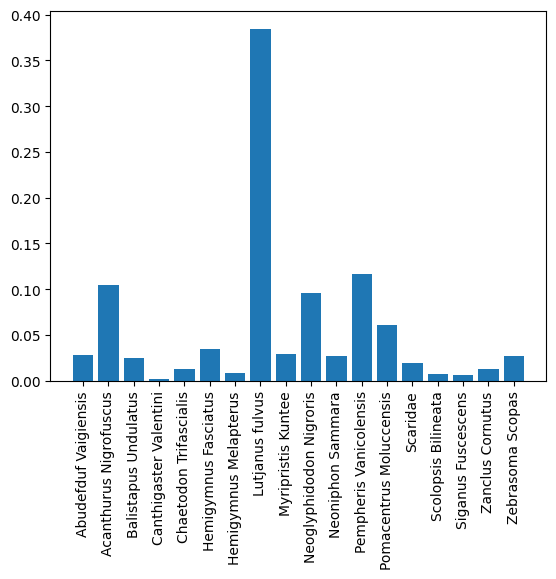

Predicted Class: Lutjanus fulvus
Confidence: 38.46%
Inference Time: 0.2694 seconds


In [51]:
class_labels = train_dataset.classes
print(class_labels)


image_path = "./data/DATASET/TEST/Lutjanus fulvus/fish_000000819594_03407.png"

random_path = './sample_images/SAMPLE_LUTJANUS.jpg'
predicted_class, confidence, prediction_time = predict_image_with_debug(torch_baseline_model, random_path, device, class_labels)


predicted_class_label = predicted_class
# confidence = prediction_probs.max().item()  # Get the highest probability
# predicted_class_index = prediction_probs.argmax().item()  # Index of the predicted class


print(f"Predicted Class: {predicted_class_label}")
print(f"Confidence: {confidence * 100:.2f}%") 
print(f"Inference Time: {prediction_time:.4f} seconds")


**OLD**

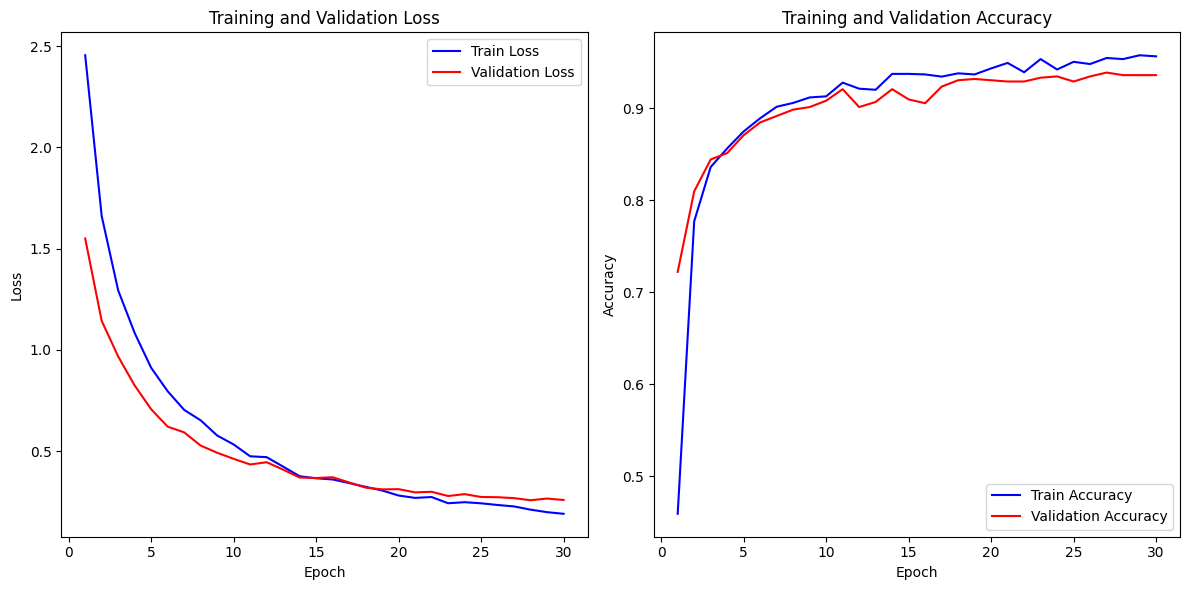

In [57]:
#not enhanced
plot_from_history(baseline_history)

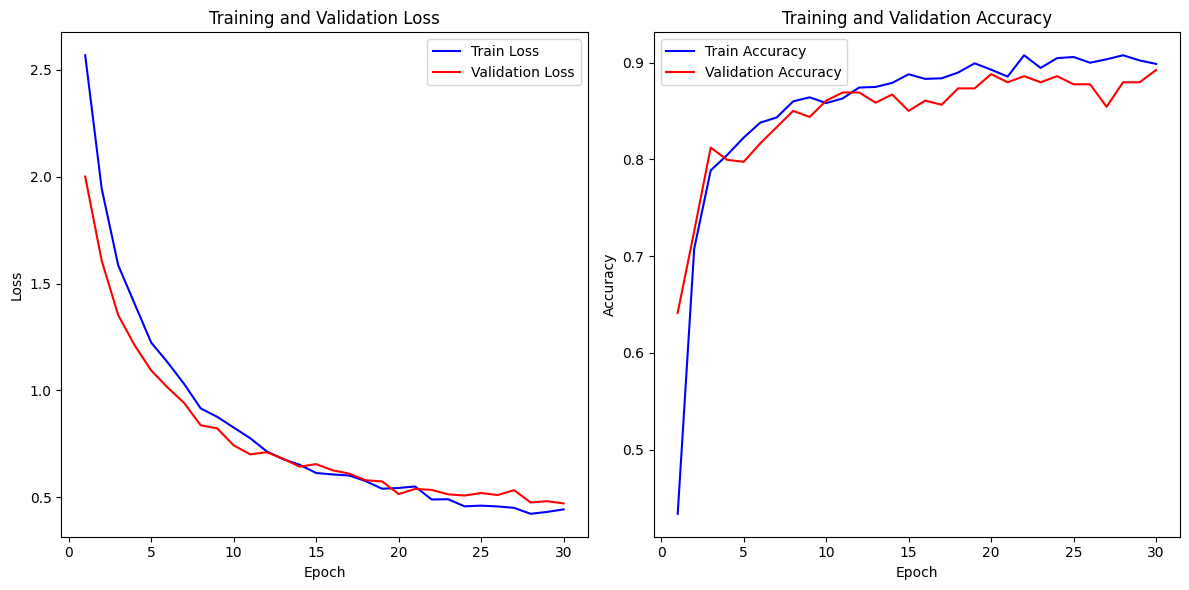

In [102]:
#enhanced
plot_from_history(baseline_history)

**NEW** with fc adamanaxx

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024BB77BF6A0>
Traceback (most recent call last):
  File "d:\workspace\ThesisProject\venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "d:\workspace\ThesisProject\venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


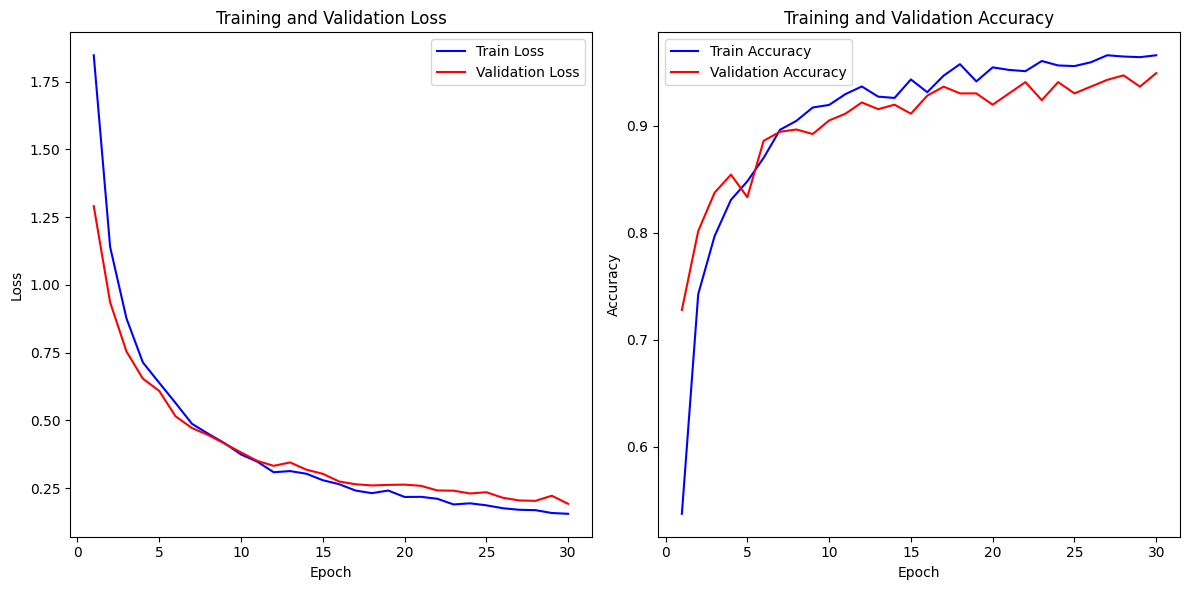

In [28]:
#not enhanced
plot_from_history(baseline_history)

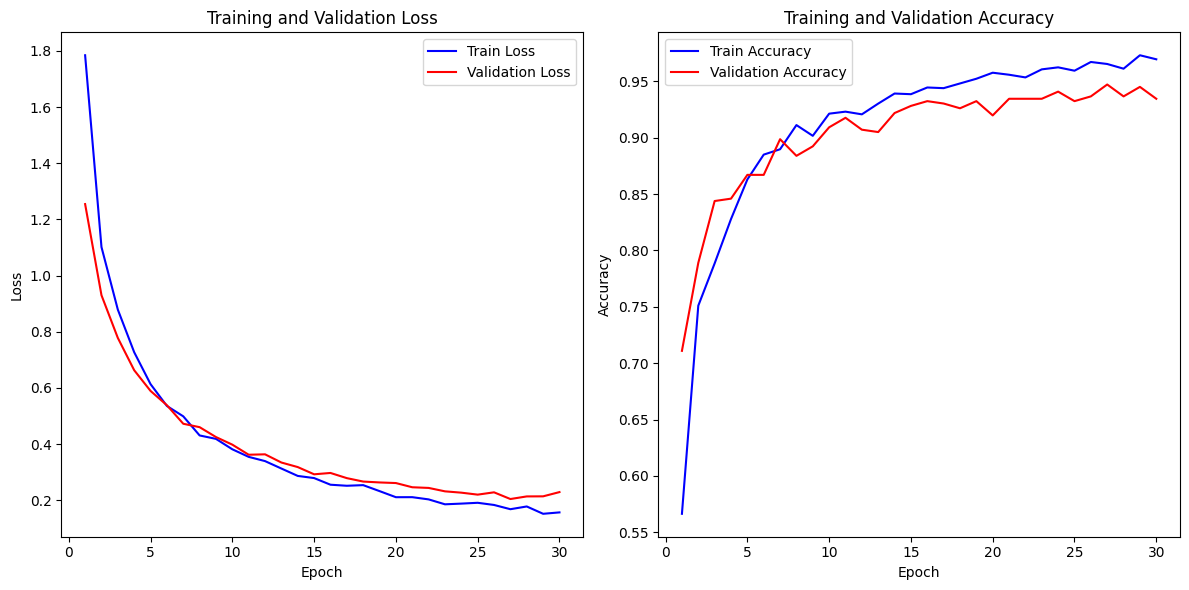

In [23]:
#enhanced
plot_from_history(baseline_history)

**END======================================Save Model======================================END**

In [58]:
import pandas as pd

df = pd.DataFrame(baseline_history)
df.to_csv('./saved_models/history/TrainAndValidate_Rightway_TEST3_torch_history_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.csv', index=False)
torch.save(torch_baseline_model, './saved_models/model/TrainAndValidate_Rightway_TEST3_torch_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.pth')
torch.save(torch_baseline_model.state_dict(), './saved_models/weights/TrainAndValidate_Rightway_TEST3_torch_weights_baselineb16notauglr001notenhancedtraintime_freezeAllEpoch30withclassweights.pth')

In [62]:
import pandas as pd

df = pd.DataFrame(baseline_history)
df.to_csv('./saved_models/history/TrainAndValidate_Rightway_TEST3_torch_history_baselineb16notauglr001ENHANCEDtraintime_freezeAllEpoch30withclassweights.csv', index=False)
torch.save(torch_baseline_model, './saved_models/model/TrainAndValidate_Rightway_TEST3_torch_baselineb16notauglr001ENHANCEDtraintime_freezeAllEpoch30withclassweights.pth')
torch.save(torch_baseline_model.state_dict(), './saved_models/weights/TrainAndValidate_Rightway_TEST3_torch_weights_baselineb16notauglr001ENHANCEDtraintime_freezeAllEpoch30withclassweights.pth')

# Proposed

In [59]:
baseline_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in baseline_model2.layers[:]:
    layer.trainable = False


for i, layer in enumerate(baseline_model2.layers):
   print(i, layer.name, layer.trainable)


0 input_layer_5 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv

In [51]:
x = baseline_model2.output







proposed_gap = GlobalAveragePooling2D()(x)
proposed_gmp = GlobalMaxPooling2D()(x)

concat = Concatenate()([proposed_gap, proposed_gmp])

x = Dropout(0.2)(concat) 

output_layer = Dense(18, activation="softmax", name='classification_output')(x)

# Final model
model3 = Model(inputs=baseline_model2.input, outputs=output_layer, name="baseline_ResNet-50")



In [52]:

initial_lr = 0.001

optimizer = Adamax(learning_rate=initial_lr)

model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
y_true = enhancedtest_generator.classes

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_true),
    y=y_true 
)

class_weight_dict = dict(enumerate(class_weights))
print(y_true)

print(class_weight_dict)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7]
{0: 1.130952380952381, 1: 1.6964285714285714, 2: 1.25, 3: 0.9895833333333334, 4: 1.1875, 5: 0.5277777777777778, 6: 0.8189655172413793, 7: 1.3194444444444444}


In [53]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00001)

baseline_history3 = model3.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=5,
    validation_freq=1,
#    class_weight = class_weight_dict,
    verbose=1,
    #callbacks=[reduce_lr]
)



Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.6218 - loss: 5.1618 - val_accuracy: 0.8629 - val_loss: 1.0657
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9555 - loss: 0.2029 - val_accuracy: 0.9451 - val_loss: 0.2478
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.9851 - loss: 0.0734 - val_accuracy: 0.9578 - val_loss: 0.2399
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.9870 - loss: 0.0687 - val_accuracy: 0.9789 - val_loss: 0.1011
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.9899 - loss: 0.0298 - val_accuracy: 0.9684 - val_loss: 0.1016


In [54]:
test_loss, test_acc = model3.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9826 - loss: 0.0834
Test Accuracy: 97.56%


In [14]:
test_loss, test_acc = model3.evaluate(enhancedtest_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy: 0.8151 - loss: 0.7468
Test Accuracy: 87.37%


**END======================================Save Model======================================END**

In [78]:
model3.save('./saved_models/proposedb8augepoch5lr0001layer81acc91enhanced94.h5')

with open('./saved_models/proposedb8augepoch5lr0001layer81acc91enhanced94_history.pkl', 'wb') as file:
    pickle.dump(baseline_history3.history, file)

**TEST THE MODEL**

In [55]:
y_pred = model3.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)  

y_true = test_generator.classes


for i in range(10):  # Checking the first 10 predictions
    print(f"True Label: {y_true[i]}, Predicted Label: {y_pred_classes[i]}")

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.92      1.00      0.96        11
 Acanthurus Nigrofuscus       0.91      1.00      0.95        21
   Balistapus Undulatus       1.00      1.00      1.00         5
 Canthigaster Valentini       1.00      0.93      0.96        14
 Chaetodon Trifascialis       0.95      0.95      0.95        19
   Hemigymnus Fasciatus       1.00      1.00      1.00        24
  Hemigymnus Melapterus       0.83      1.00      0.91         5
        Lutjanus fulvus       0.95      1.00      0.98        20
     Myriprist

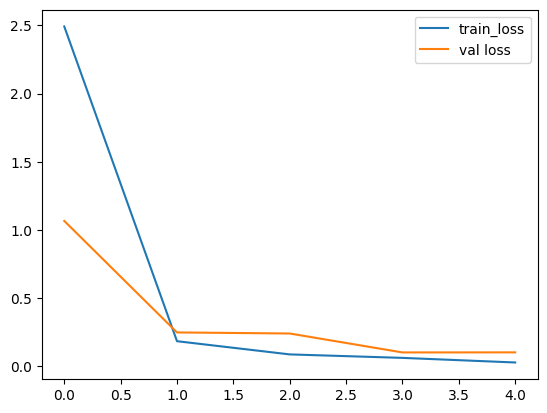

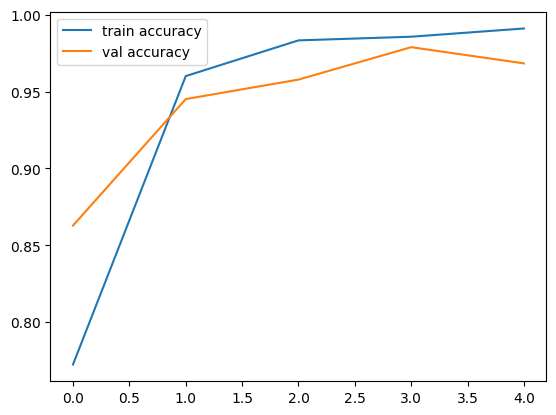

In [56]:
# Plot the Loss

plt.plot(baseline_history3.history['loss'], label = 'train_loss')
plt.plot(baseline_history3.history['val_loss'], label ='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# Plot the Accuracy
plt.plot(baseline_history3.history['accuracy'], label = 'train accuracy')
plt.plot(baseline_history3.history['val_accuracy'], label ='val accuracy')
plt.legend()
plt.show()
# plt.savefig('valAccuracy')


# PYTORCH (PROPOSED)

In [ ]:
learning_rate = 0.001
epochs = 30

torch_proposed = resnet50(weights="IMAGENET1K_V1")
torch_proposed = torch_proposed.to(device)

# FREEZE ALL LAYERS
for name, layer in torch_proposed.named_modules():
    for param in layer.parameters():
        param.requires_grad = False

class ProposedResNet(nn.Module):
    def __init__(self, base_model, num_classes=18, dropout_rate=0.5):
        super(ProposedResNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude top layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.gmp = nn.AdaptiveMaxPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(4096, num_classes)  # 2048 (gap) + 2048 (gmp) = 4096

    def forward(self, x):
        x = self.base_model(x)
        gap = self.gap(x).view(x.size(0), -1)
        gmp = self.gmp(x).view(x.size(0), -1)
        concat = torch.cat((gap, gmp), dim=1)
        concat = self.dropout(concat)
        x = self.fc(concat)
        return x


torch_proposed_model = ProposedResNet(torch_proposed).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adamax(torch_proposed_model.fc.parameters, lr=learning_rate)


for name, layer in torch_proposed_model.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')


: True
base_model: False
base_model.0: False
base_model.1: False
base_model.2: False
base_model.3: False
base_model.4: False
base_model.4.0: False
base_model.4.0.conv1: False
base_model.4.0.bn1: False
base_model.4.0.conv2: False
base_model.4.0.bn2: False
base_model.4.0.conv3: False
base_model.4.0.bn3: False
base_model.4.0.relu: False
base_model.4.0.downsample: False
base_model.4.0.downsample.0: False
base_model.4.0.downsample.1: False
base_model.4.1: False
base_model.4.1.conv1: False
base_model.4.1.bn1: False
base_model.4.1.conv2: False
base_model.4.1.bn2: False
base_model.4.1.conv3: False
base_model.4.1.bn3: False
base_model.4.1.relu: False
base_model.4.2: False
base_model.4.2.conv1: False
base_model.4.2.bn1: False
base_model.4.2.conv2: False
base_model.4.2.bn2: False
base_model.4.2.conv3: False
base_model.4.2.bn3: False
base_model.4.2.relu: False
base_model.5: False
base_model.5.0: False
base_model.5.0.conv1: False
base_model.5.0.bn1: False
base_model.5.0.conv2: False
base_model.5.0.

In [7]:
# Train model
proposed_history = train_model(torch_proposed_model, train_loader, test_loader, optimizer, criterion, epochs=epochs, device=device)

Epoch 1/30: 100%|██████████████████| 105/105 [00:35<00:00,  2.96batch/s, accuracy=0.256, loss=0.208]


Epoch 1/30: Train Loss=3.3191, Train Acc=0.2561, Val Loss=1.5801, Val Acc=0.6962


Epoch 2/30: 100%|███████████████████| 105/105 [01:13<00:00,  1.43batch/s, accuracy=0.541, loss=0.12]


Epoch 2/30: Train Loss=1.9146, Train Acc=0.5414, Val Loss=0.9543, Val Acc=0.7806


Epoch 3/30:  13%|██▌                | 14/105 [00:23<02:35,  1.71s/batch, accuracy=0.589, loss=0.105]


KeyboardInterrupt: 

In [54]:
# Train model
proposed_history = train_model(torch_proposed_model, enhanced_train_loader, enhanced_val_loader, optimizer, criterion, epochs=epochs, device=device)

Epoch 1/5: 100%|████████████████████| 53/53 [00:28<00:00,  1.87batch/s, accuracy=0.377, loss=0.0848]


Epoch 1/5: Train Loss=2.6873, Train Acc=0.3770, Val Loss=1.5467, Val Acc=0.6382


Epoch 2/5: 100%|████████████████████| 53/53 [00:28<00:00,  1.88batch/s, accuracy=0.683, loss=0.0383]


Epoch 2/5: Train Loss=1.2139, Train Acc=0.6831, Val Loss=1.1153, Val Acc=0.7358


Epoch 3/5: 100%|████████████████████| 53/53 [00:27<00:00,  1.92batch/s, accuracy=0.746, loss=0.0297]


Epoch 3/5: Train Loss=0.9404, Train Acc=0.7463, Val Loss=0.9365, Val Acc=0.8089


Epoch 4/5: 100%|█████████████████████| 53/53 [00:27<00:00,  1.92batch/s, accuracy=0.79, loss=0.0245]


Epoch 4/5: Train Loss=0.7758, Train Acc=0.7904, Val Loss=0.8536, Val Acc=0.8089


Epoch 5/5: 100%|████████████████████| 53/53 [00:28<00:00,  1.88batch/s, accuracy=0.808, loss=0.0218]


Epoch 5/5: Train Loss=0.6899, Train Acc=0.8082, Val Loss=0.7076, Val Acc=0.8293


In [59]:

# Test model and evaluate performance
y_true, y_pred = test_model(torch_proposed_model, enhanced_test_loader)

print("\nClassification Report:")
class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       1.00      0.42      0.59        19
 Acanthurus Nigrofuscus       0.81      0.70      0.75        43
   Balistapus Undulatus       0.86      0.75      0.80         8
 Canthigaster Valentini       0.76      0.97      0.85        29
 Chaetodon Trifascialis       0.77      0.87      0.81        38
   Hemigymnus Fasciatus       0.84      0.85      0.85        48
  Hemigymnus Melapterus       1.00      0.25      0.40         8
        Lutjanus fulvus       0.98      0.98      0.98        41
     Myripristis Kuntee       0.86      0.96      0.91        90
Neoglyphidodon Nigroris       0.00      0.00      0.00         3
      Neoniphon Sammara       0.92      1.00      0.96        59
 Pempheris Vanicolensis       1.00      1.00      1.00         5
Pomacentrus Moluccensis       0.88      1.00      0.94        36
               Scaridae       0.58      0.64      0.61        11


d:\workspace\ThesisProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\workspace\ThesisProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\workspace\ThesisProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\workspace\Thesis

In [ ]:

# Test model and evaluate performance
y_true, y_pred = test_model(torch_proposed_model, test_loader)

print("\nClassification Report:")
class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

**TEST ON SAMPLE IMAGE**

['Abudefduf Vaigiensis', 'Acanthurus Nigrofuscus', 'Balistapus Undulatus', 'Canthigaster Valentini', 'Chaetodon Trifascialis', 'Hemigymnus Fasciatus', 'Hemigymnus Melapterus', 'Lutjanus fulvus', 'Myripristis Kuntee', 'Neoglyphidodon Nigroris', 'Neoniphon Sammara', 'Pempheris Vanicolensis', 'Pomacentrus Moluccensis', 'Scaridae', 'Scolopsis Bilineata', 'Siganus Fuscescens', 'Zanclus Cornutus', 'Zebrasoma Scopas']
Logits: tensor([[-1.6972, -3.5669, -0.9817,  2.1569,  5.6750,  1.2796, -1.2186, -1.6959,
         -1.7428, -0.8209, -1.0790,  2.1686,  2.7590, -2.2121, -2.0770, -0.3907,
          2.3496, -0.6949]], device='cuda:0')


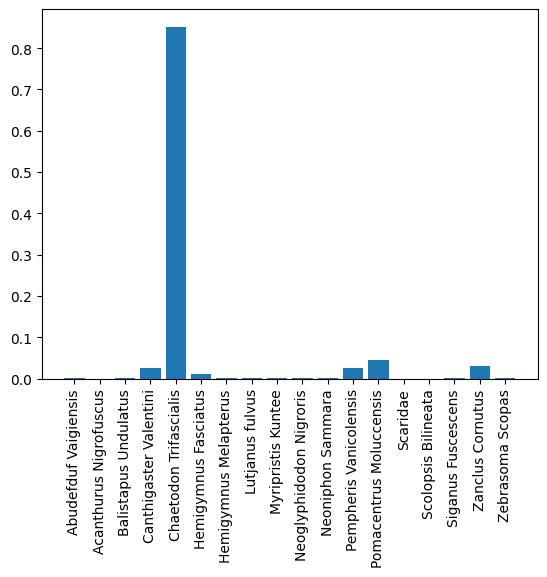

Predicted Class: Chaetodon Trifascialis
Confidence: 85.19%
Inference Time: 0.3723 seconds


In [92]:
class_labels = train_dataset.classes
print(class_labels)

image_path = "./sample_images/Chaetodon Trifascialis.jpg"

predicted_class, confidence, prediction_time = predict_image_with_debug(torch_proposed_model, image_path, device, class_labels)

predicted_class_label = predicted_class
# confidence = prediction_probs.max().item()  # Get the highest probability
# predicted_class_index = prediction_probs.argmax().item()  # Index of the predicted class


print(f"Predicted Class: {predicted_class_label}")
print(f"Confidence: {confidence * 100:.2f}%")  
print(f"Inference Time: {prediction_time:.4f} seconds")

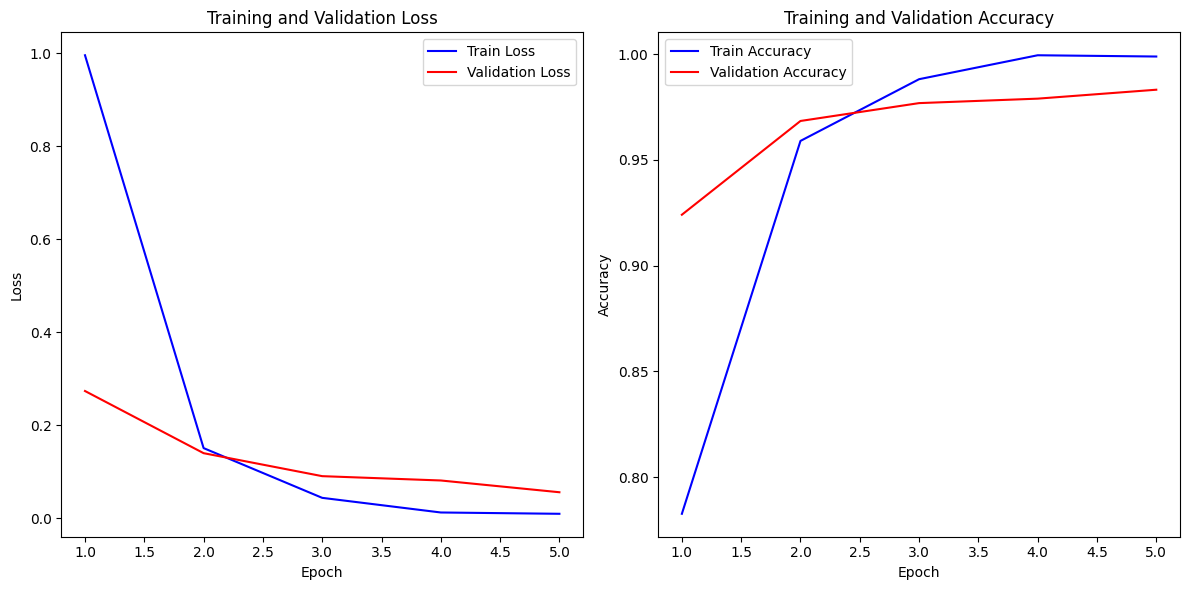

In [67]:
plot_from_history(proposed_history)

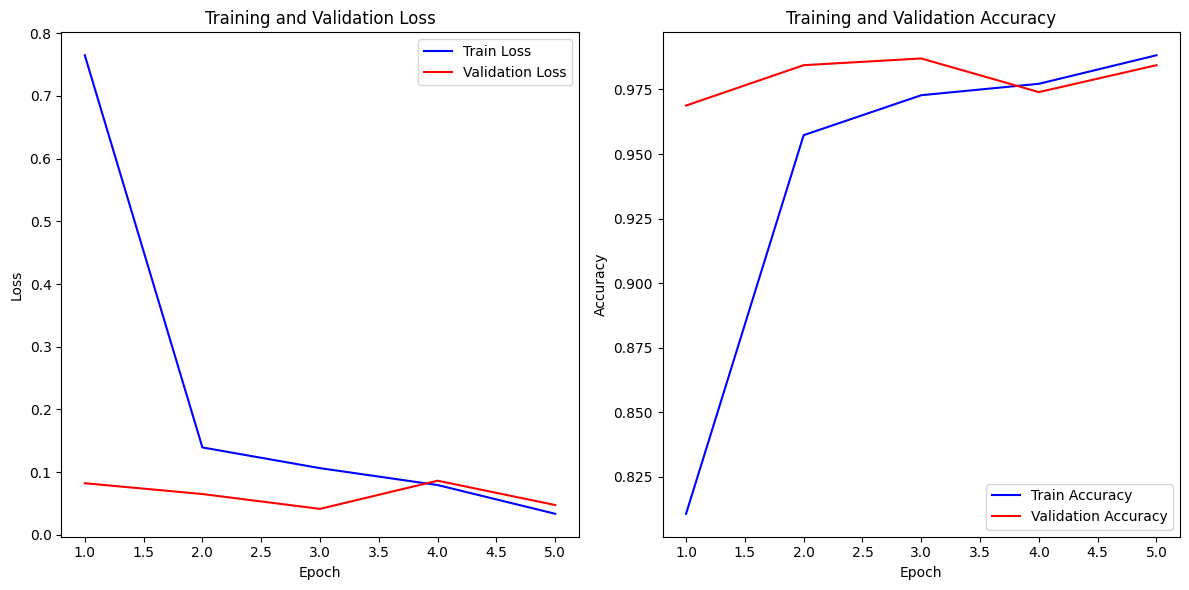

In [30]:
history_df = pd.read_csv('./saved_models/torch_proposedb8aug1lr001vallacc98testacc100traintime4m15s_history.csv')

history = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}

plot_from_history(history)

**END======================================Save Model======================================END**

In [49]:
import pandas as pd

df = pd.DataFrame(proposed_history)
df.to_csv('torch_proposedb16aug1lr001vallacc99testacc100traintime4m15s_history.csv', index=False)
torch.save(model6, './saved_models/torch_proposedb16aug1lr001vallacc99testacc100traintime4m15s.pth')
torch.save(model6.state_dict(), './saved_models/torch_weights_proposedb16aug1lr001vallacc99testacc100traintime4m15s.pth')